In [70]:
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from time import time

Работа с настоящими новостями

In [71]:
true_news_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
true_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [72]:
true_news_df.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [73]:
true_news_df['is_true'] = [1] * len(true_news_df)
true_news_df.head()

,title,text,subject,date,is_true
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [74]:
duplicates_count = true_news_df.duplicated().sum()

print(f"Количество дубликатов в датафрейме: {duplicates_count}")

Количество дубликатов в датафрейме: 206


In [75]:
true_news_df = true_news_df.drop_duplicates()
true_news_df

,title,text,subject,date,is_true
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


Работа с фейк новостями

In [76]:
fake_news_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [77]:
fake_news_df.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [78]:
fake_news_df['is_true'] = [0] * len(fake_news_df)
fake_news_df.head()

,title,text,subject,date,is_true
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [79]:
fake_news_df = fake_news_df.drop_duplicates()
fake_news_df

,title,text,subject,date,is_true
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


Объединение 2 датафреймов

In [80]:
all_news_df = pd.concat([true_news_df, fake_news_df], ignore_index=True)
all_news_df

,title,text,subject,date,is_true
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44684,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44685,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44686,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44687,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [81]:
average_word_length = all_news_df['text'].str.split().str.len().mean()

print(f"Средняя длина новости по словам: {average_word_length} слов")

Средняя длина новости по словам: 404.966501823715 слов


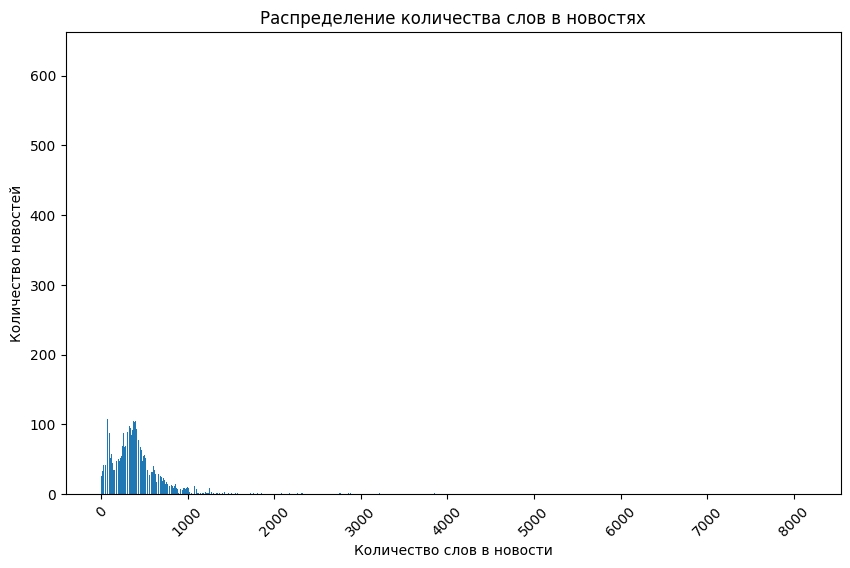

In [82]:
word_counts = all_news_df['text'].str.split().str.len()

# Подготовка данных для диаграммы
word_counts_series = pd.Series(word_counts).value_counts().sort_index()

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
plt.bar(word_counts_series.index, word_counts_series.values)
plt.xlabel('Количество слов в новости')
plt.ylabel('Количество новостей')
plt.title('Распределение количества слов в новостях')
plt.xticks(rotation=45)
plt.show()

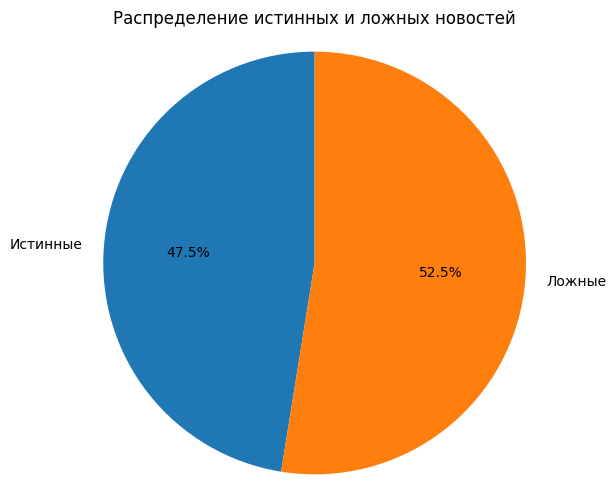

In [83]:
true_count = all_news_df['is_true'].value_counts().get(1, 0)
false_count = all_news_df['is_true'].value_counts().get(0, 0)

labels = ['Истинные', 'Ложные']
sizes = [true_count, false_count]

# Создание круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal') 
plt.title('Распределение истинных и ложных новостей')
plt.show()

In [84]:
# def vectorize_text(text_column, model_name="bert-base-uncased"):
#     # Загрузка токенизатора и модели
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)
    
#     # Инициализация списка для хранения векторных представлений
#     vectors = []
    
#     # Преобразование каждого текста в векторное представление
#     for text in text_column:
#         inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#         with torch.no_grad():
#             outputs = model(**inputs)
#         last_hidden_state = outputs.last_hidden_state
#         # Принимаем среднее значение векторов слов в тексте как векторное представление текста
#         text_vector = torch.mean(last_hidden_state, dim=1).numpy()
#         vectors.append(text_vector)
    
#     return vectors


# all_news_df['text_vector'] = vectorize_text(all_news_df['text'])

In [85]:
X = all_news_df[["title", "text"]]
y = all_news_df["is_true"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
X_train

,title,text
7001,Trump faces dilemma as U.S. oil reels from rec...,NEW YORK (Reuters) - The Obama administration ...
5219,Trump's trade czar expected to get easy U.S. S...,WASHINGTON (Reuters) - Billionaire investor Wi...
39969,SHOCKER! CNN PANEL Rips On DNC Chair For His D...,What a shocker! A CNN panel rips on Tom Perez ...
24275,Comey Refuses To Say If FBI Is Investigating ...,If you had any doubt left about whether FBI Di...
42117,THE FIX IS IN: Michigan Mayor Threatened By DN...,Here is a screen shot of the Facebook post by ...
...,...,...
6265,Germany's Schaeuble warns Trump over protectio...,BERLIN (Reuters) - German Finance Minister Wol...
11284,"Twenty-eight arrests after Venezuela looting, ...","PUERTO ORDAZ, Venezuela (Reuters) - Venezuelan..."
38158,HOW THE FBI Cracked A Terror Plot On Black Fri...,The U.S. is the great enemy of mankind! rave...
860,U.S. tax plan threatens Wall Street's Bermuda ...,NEW YORK (Reuters) - U.S. money managers with ...


Векторизация TF-IDF

In [87]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["title"] + " " + X_train["text"])
X_test_tfidf = tfidf_vectorizer.transform(X_test["title"] + " " + X_test["text"])

In [88]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    # Список моделей для обучения
    models = [
        ('Multinomial Naive Bayes', MultinomialNB()),
        ('Logistic Regression', LogisticRegression(max_iter=1000)),
        ('Decision Tree', DecisionTreeClassifier()),
        ('Random Forest', RandomForestClassifier()),
        ('Dummy Classifier', DummyClassifier(strategy='most_frequent'))  # Простой дамми-классификатор
    ]
    
    results = []
    
    for name, model in models:
        start_time = time()
        
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        mean_accuracy = scores.mean()
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Вычисление метрик качества
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Округление значений до трех знаков после запятой
        accuracy = round(accuracy, 3)
        f1 = round(f1, 3)
        training_time = round(time() - start_time, 3)
        
        # Запись результатов в список
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Training Time': training_time
        })
        print(results[-1])
    
    # Создание DataFrame из списка результатов
    results_df = pd.DataFrame(results)
    
    return results_df

# Пример использования функции
results = train_and_evaluate_models(X_train_tfidf, y_train, X_test_tfidf, y_test)
print(results)

{'Model': 'Multinomial Naive Bayes', 'Accuracy': 0.942, 'F1 Score': 0.942, 'Training Time': 0.604}
{'Model': 'Logistic Regression', 'Accuracy': 0.986, 'F1 Score': 0.986, 'Training Time': 25.388}
{'Model': 'Decision Tree', 'Accuracy': 0.996, 'F1 Score': 0.996, 'Training Time': 188.374}
{'Model': 'Random Forest', 'Accuracy': 0.99, 'F1 Score': 0.99, 'Training Time': 482.158}
{'Model': 'Dummy Classifier', 'Accuracy': 0.52, 'F1 Score': 0.356, 'Training Time': 0.126}
                     Model  Accuracy  F1 Score  Training Time
0  Multinomial Naive Bayes     0.942     0.942          0.604
1      Logistic Regression     0.986     0.986         25.388
2            Decision Tree     0.996     0.996        188.374
3            Random Forest     0.990     0.990        482.158
4         Dummy Classifier     0.520     0.356          0.126


In [89]:
results

,Model,Accuracy,F1 Score,Training Time
0,Multinomial Naive Bayes,0.942,0.942,0.604
1,Logistic Regression,0.986,0.986,25.388
2,Decision Tree,0.996,0.996,188.374
3,Random Forest,0.990,0.990,482.158
4,Dummy Classifier,0.520,0.356,0.126
